In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

**Loading the dataset**

In [2]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, phase, transform):
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform

        self.image_paths = []
        self.clean_paths = []
        self.mask_paths = []

        # Iterate through all classes in the root directory
        self.classes = os.listdir(root_dir)
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            phase_dir = os.path.join(class_path, self.phase)

            # Check if phase_dir exists
            if os.path.exists(phase_dir):
                print(f"Processing class: {class_name} in {phase_dir}")  # Debugging statement
                
                for folder_type in ['Defect_mask', 'Degraded_image', 'GT_clean_image']:
                    self._load_images_for_folder_type(phase_dir, folder_type)

    def _load_images_for_folder_type(self, phase_dir, folder_type):
        folder_path = os.path.join(phase_dir, folder_type)
        print(f"Looking for folder: {folder_path}")  # Debugging statement

        # Ensure the folder exists before loading
        if os.path.exists(folder_path):
            for defect_type in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, defect_type)
                print(f"Checking subfolder: {subfolder_path}")  # Debugging statement

                # Ensure subfolder exists
                if os.path.isdir(subfolder_path):
                    for image_name in os.listdir(subfolder_path):
                        image_path = os.path.join(subfolder_path, image_name)

                        # Append paths based on the folder type
                        if folder_type == 'Degraded_image':
                            self.image_paths.append(image_path)
                        elif folder_type == 'GT_clean_image':
                            self.clean_paths.append(image_path)
                        elif folder_type == 'Defect_mask':
                            self.mask_paths.append(image_path)

                    # Print how many images were loaded from each subfolder
                    print(f"Loaded {len(os.listdir(subfolder_path))} images from {subfolder_path}")
                              #Ensure all paths are loaded consistently
                    print(f"Loaded {len(self.image_paths)} degraded images, {len(self.clean_paths)} clean images, {len(self.mask_paths)} masks from {folder_type}.")
        else:
            print(f"Folder does not exist: {folder_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load images using PIL
        degraded_image = Image.open(self.image_paths[idx]).convert('RGB')
        clean_image = Image.open(self.clean_paths[idx]).convert('RGB')
        mask_image = Image.open(self.mask_paths[idx])  # Grayscale mask

        # Apply any transformations if specified
        if self.transform:
            degraded_image = self.transform(degraded_image)
            clean_image = self.transform(clean_image)
            mask_image = self.transform(mask_image)

        return degraded_image, clean_image, mask_image


In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
dataset_path = '/home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val'

In [5]:
test_dataset = MVTecDataset(root_dir=dataset_path, phase='Val', transform=transform)  #For time being keeping phase ='Val' need to change to 'Test' at time of evaluation

Processing class: grid in /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val
Looking for folder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask
Checking subfolder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/metal_contamination
Loaded 1 images from /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/metal_contamination
Loaded 0 degraded images, 0 clean images, 1 masks from Defect_mask.
Checking subfolder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/bent
Loaded 1 images from /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/bent
Loaded 0 degraded images, 0 clean images, 2 masks from Defect_mask.
Checking subfolder: /home/user/Downloa

In [6]:
print(f"Total number of degraded images: {len(test_dataset.image_paths)}")
print(f"Total number of clean images: {len(test_dataset.clean_paths)}")
print(f"Total number of defect masks: {len(test_dataset.mask_paths)}")

Total number of degraded images: 88
Total number of clean images: 88
Total number of defect masks: 88


In [7]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

Displaying sample images

In [8]:

degraded_img, clean_img, mask_img = test_dataset[0]  # Access the first sample


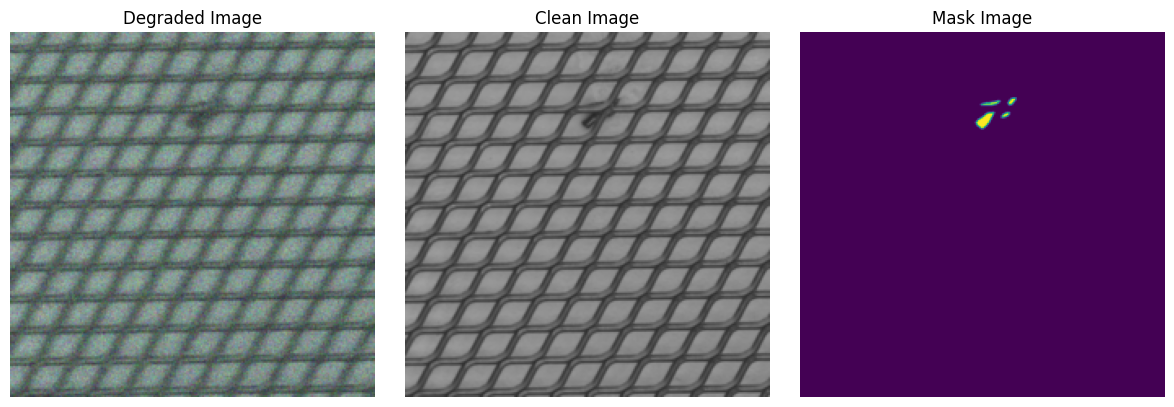

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose images if needed (assuming they are (3, 224, 224))
degraded_img = np.transpose(degraded_img, (1, 2, 0))
clean_img = np.transpose(clean_img, (1, 2, 0))
mask_img = np.transpose(mask_img, (1, 2, 0))

# Set up a figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot each image in a separate subplot
axs[0].imshow(degraded_img)
axs[0].axis('off')
axs[0].set_title('Degraded Image')

axs[1].imshow(clean_img)
axs[1].axis('off')
axs[1].set_title('Clean Image')

axs[2].imshow(mask_img)
axs[2].axis('off')
axs[2].set_title('Mask Image')

plt.tight_layout()  # Optional: adjusts spacing between plots for a cleaner look
plt.show()

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
import skimage.metrics
import numpy as np

def calculate_metrics(original, restored):
    # Ensure images are in float32 format
    original = original.astype(np.float32)
    restored = restored.astype(np.float32)

    # Ensure the images are in the expected range
    original = np.clip(original, 0, 1)
    restored = np.clip(restored, 0, 1)

    # Calculate PSNR
    psnr_value = skimage.metrics.peak_signal_noise_ratio(original, restored, data_range=1.0)

    # Debugging: Print shapes and dtypes
    print(f"Original shape: {original.shape}, Restored shape: {restored.shape}")
    print(f"Original dtype: {original.dtype}, Restored dtype: {restored.dtype}")

    # Dynamically adjust win_size for SSIM
    min_dim = min(original.shape[:2])  # Get the smallest dimension
    win_size = min(11, min_dim) if min_dim % 2 == 1 else min(11, min_dim - 1)

    # Calculate SSIM with appropriate parameters
    ssim_value = skimage.metrics.structural_similarity(
        original,
        restored,
        data_range=1.0,
        win_size=win_size,
        channel_axis=-1  # Set to -1 if channels are in the last dimension
    )
    
    return psnr_value, ssim_value


**Autoencoder Model**

In [12]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # (N, 3, H, W) -> (N, 64, H, W)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (N, 64, H, W) -> (N, 128, H/2, W/2)
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding =1),  # (N, 128, H, W) -> (N, 64, H, W)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),  # (N, 64, H, W) -> (N, 3, H, W)
            nn.Sigmoid(),  # Normalize output to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


**Loading the model**

In [13]:
#Loading the model
#Loading from the entire model
# Load the entire model
model_AE = torch.load('ae_model_full_updated.pth')
model_AE = model_AE.to(device)  # Move to the appropriate device
#model_AE.eval()  # Set to evaluation mode for inference


/tmp/ipykernel_3160195/223967388.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_AE = torch.load('ae_model_full_updated.pth')


Loading the model weights

In [14]:
#Loading from only the weights
# Initialize the model (redefine architecture)
model_AE = Autoencoder().to(device)


# Load the state dictionary (weights)
model_AE.load_state_dict(torch.load('ae_model_updated_weights.pth'))

# Set to evaluation mode for inference
#model_AE.eval()




/tmp/ipykernel_3160195/752929239.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_AE.load_state_dict(torch.load('ae_model_updated_weights.pth'))


<All keys matched successfully>

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 26.69518505072794, SSIM: 0.703315794467926


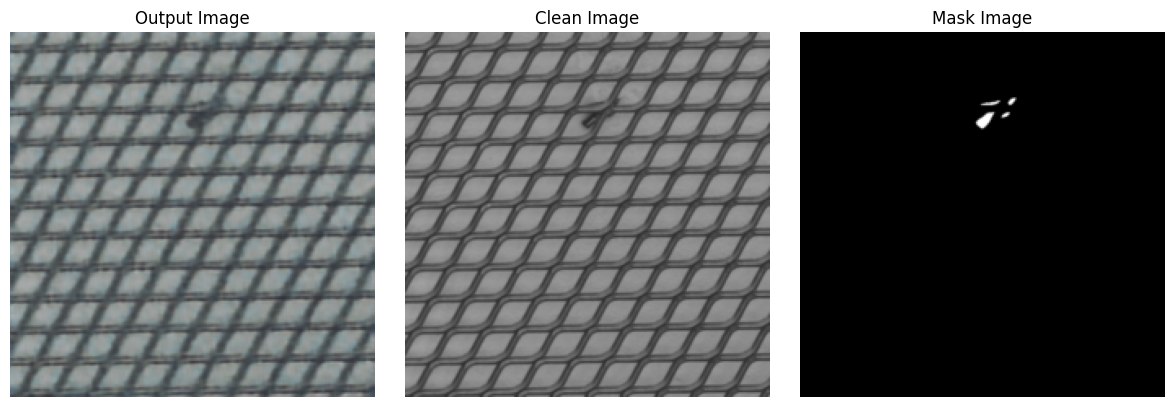

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 25.545047125650058, SSIM: 0.7156935930252075
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 25.01837883341566, SSIM: 0.722366988658905
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 25.628645410752075, SSIM: 0.796241819858551
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 25.862133088550237, 

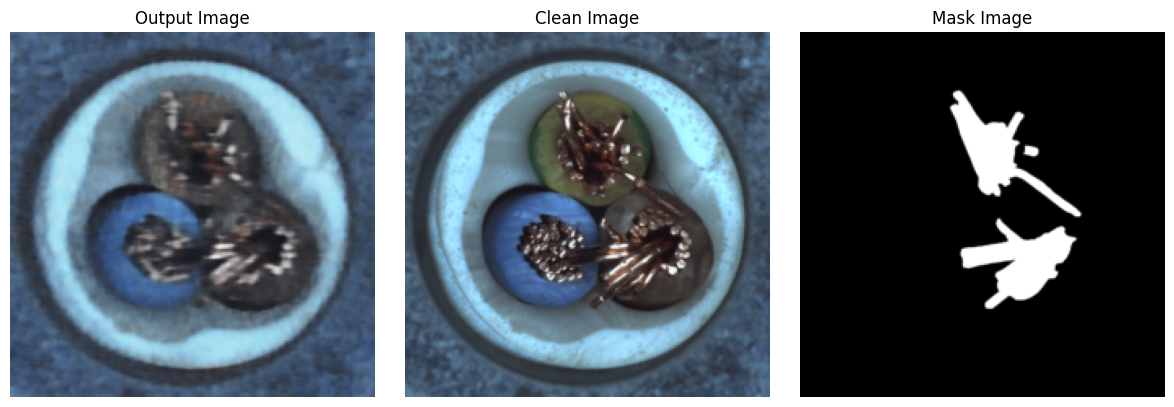

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 28.32127289377029, SSIM: 0.9109726548194885
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 26.060235242715084, SSIM: 0.8209396004676819
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 26.808557412884166, SSIM: 0.8305854201316833
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 27.64820913026648,

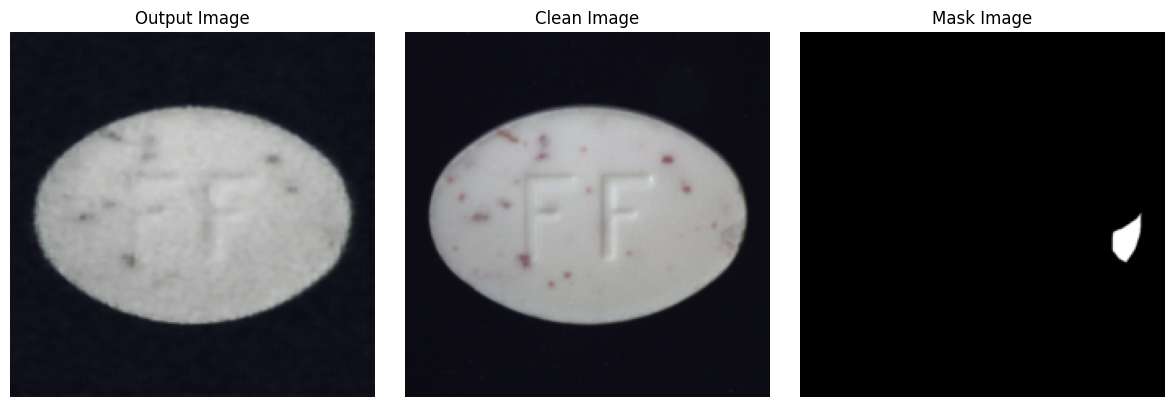

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 32.61158221604197, SSIM: 0.9385998845100403
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 28.145367701563178, SSIM: 0.9342244267463684
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 32.706108263463264, SSIM: 0.9401488304138184
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 26.642355733674663

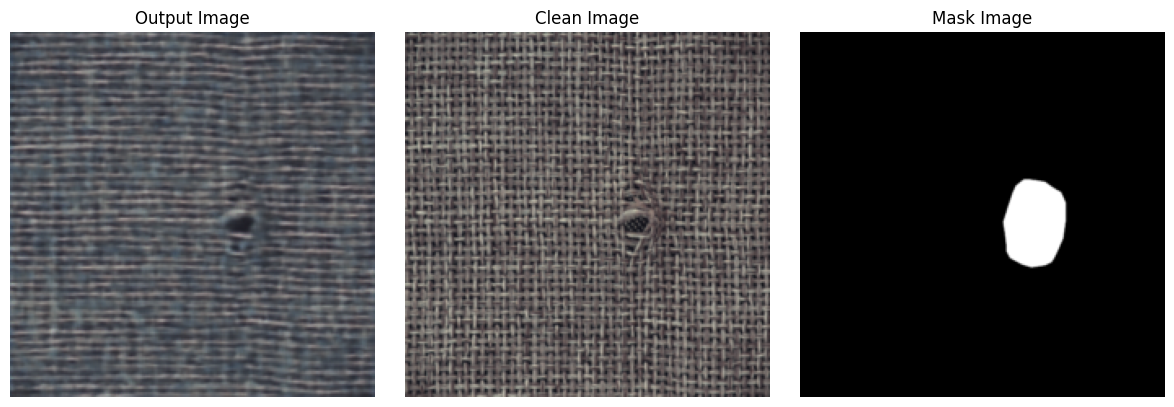

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 22.998297152964305, SSIM: 0.7357390522956848
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 22.695824228263884, SSIM: 0.761961817741394
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 22.8197433318217, SSIM: 0.7928417325019836
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 22.3250832922696, SS

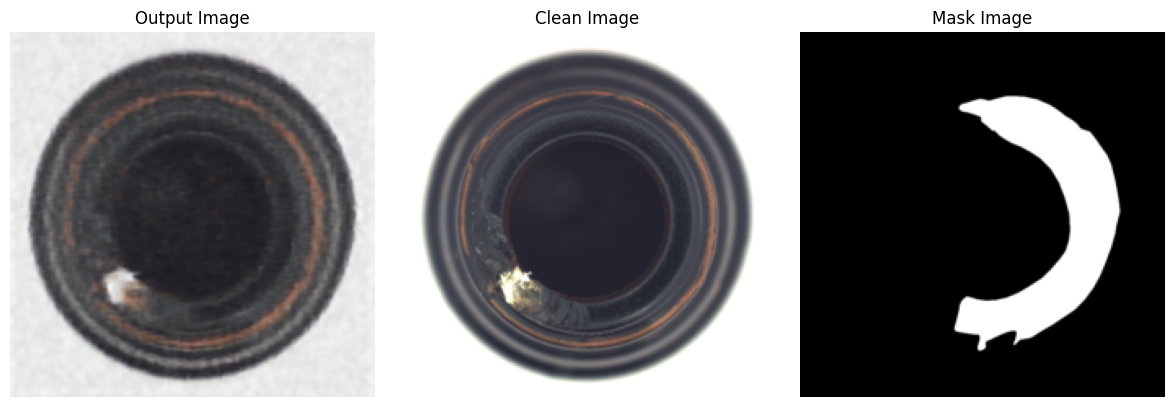

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 29.90351647185918, SSIM: 0.8864129185676575
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 29.91473139260542, SSIM: 0.8853667378425598
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 27.49071080486867, SSIM: 0.8634027242660522
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 28.827246914072454, 

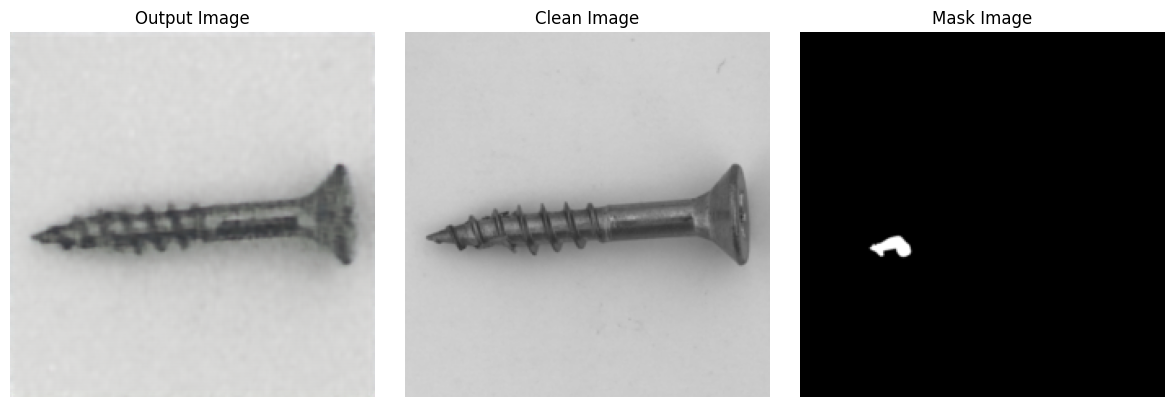

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 28.915108464925044, SSIM: 0.5780473351478577
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 27.935615278890907, SSIM: 0.9532898664474487
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 31.524312698645982, SSIM: 0.9493536353111267
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 32.16244808227427

In [15]:
# Load test or validation dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  #Currently given bathc_size = 1

psnr_values = []
ssim_values = []

with torch.no_grad():
    for degraded, clean, mask in test_loader:
        degraded = degraded.to(device)
        outputs = model_AE(degraded)

        # Convert tensors to numpy arrays for each image in the batch
        output_images = outputs.cpu().numpy()
        clean_images = clean.cpu().numpy()
        mask_images = mask.cpu().numpy()

        # Loop through each image in the batch
        for i in range(output_images.shape[0]):
            output_image = output_images[i].squeeze()
            clean_image = clean_images[i].squeeze()
            mask_image = mask_images[i].squeeze()

            # Check image shapes before calculating metrics
            print(f'Clean image shape: {clean_image.shape}')
            print(f'Output image shape: {output_image.shape}')
            print(f'Mask image shape: {mask_image.shape}')

            # Calculate metrics for each image
            psnr, ssim = calculate_metrics(clean_image, output_image)
            print(f'PSNR: {psnr}, SSIM: {ssim}')

            if i==0:  #Instead of showing all images in each batch, I am showing only first image in each batch for not to exceed file size while uploading in github

                # Transpose if necessary for visualization
                output_img = np.transpose(output_image, (1, 2, 0)) if output_image.ndim == 3 else output_image
                clean_img = np.transpose(clean_image, (1, 2, 0)) if clean_image.ndim == 3 else clean_image
                mask_img = np.transpose(mask_image, (1, 2, 0)) if mask_image.ndim == 3 else mask_image

                # Set up a figure with 1 row and 3 columns
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                # Plot each image in a separate subplot
                axs[0].imshow(output_img)
                axs[0].axis('off')
                axs[0].set_title('Output Image')

                axs[1].imshow(clean_img)
                axs[1].axis('off')
                axs[1].set_title('Clean Image')

                axs[2].imshow(mask_img, cmap='gray')
                axs[2].axis('off')
                axs[2].set_title('Mask Image')

                plt.tight_layout()
                plt.show()

            psnr_values.append(psnr)
            ssim_values.append(ssim)

    # Calculate average PSNR and SSIM
    average_psnr = np.mean(psnr_values)
    average_ssim = np.mean(ssim_values)

# Print average values
print(f"Average PSNR for the entire test set: {average_psnr:.2f}")
print(f"Average SSIM for the entire test set: {average_ssim:.2f}")


Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 51.967755931555, Defect SSIM: 0.9994645118713379


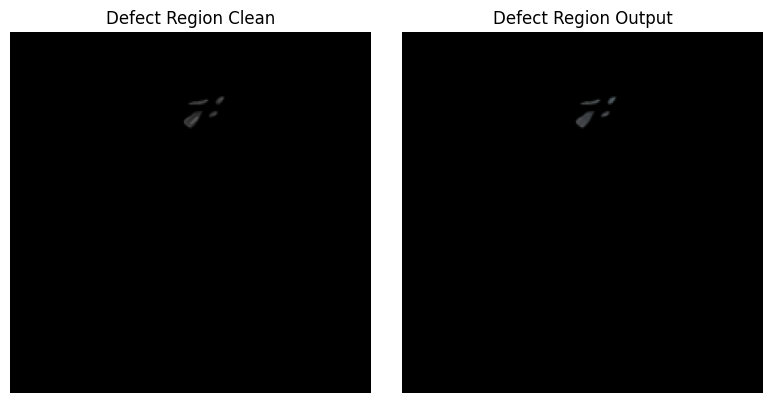

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 41.79942341195058, Defect SSIM: 0.9985231757164001
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 46.6939821144006, Defect SSIM: 0.9993794560432434
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.219045485185944, Defect SSIM: 0.9964172840118408
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 45.70719191367564, Defect SSIM: 0.9991429448127747
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 48.79443978483869, Defect SSIM: 0.9971638321876526
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 40.7044

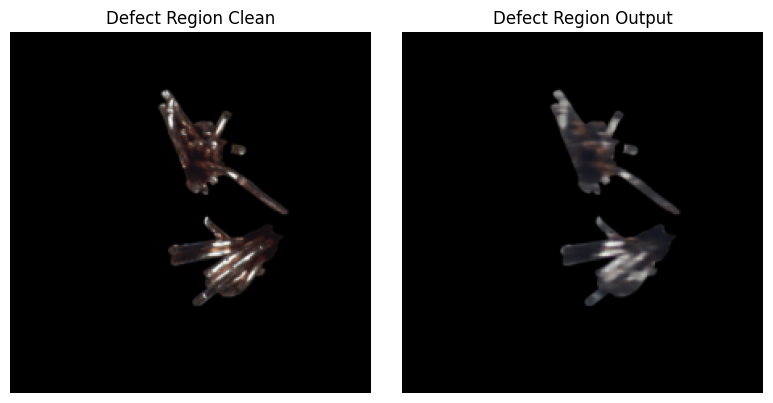

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.35027192658227, Defect SSIM: 0.997697651386261
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 38.843279823399186, Defect SSIM: 0.9897541999816895
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.464019608023925, Defect SSIM: 0.9901080131530762
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 47.99609273308319, Defect SSIM: 0.9992246627807617
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.8098573533599, Defect SSIM: 0.9956013560295105
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 31.8098

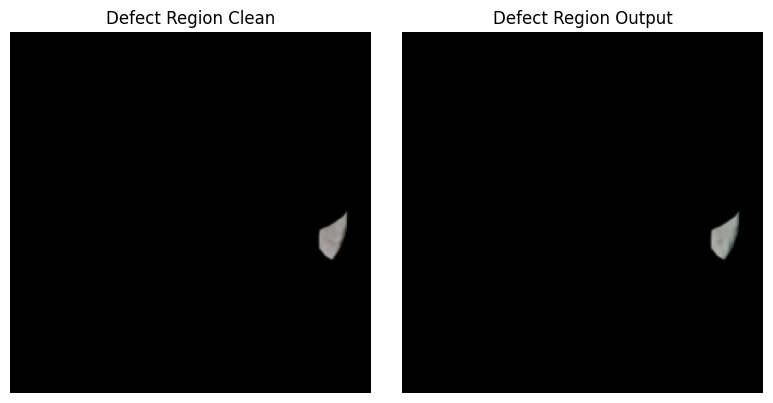

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 49.57637875028607, Defect SSIM: 0.998952329158783
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.5437622408221, Defect SSIM: 0.999293327331543
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 46.40648906026129, Defect SSIM: 0.9988277554512024
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 28.936401855632003, Defect SSIM: 0.8631141781806946
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.730914551016035, Defect SSIM: 0.9988088607788086
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 49.11387

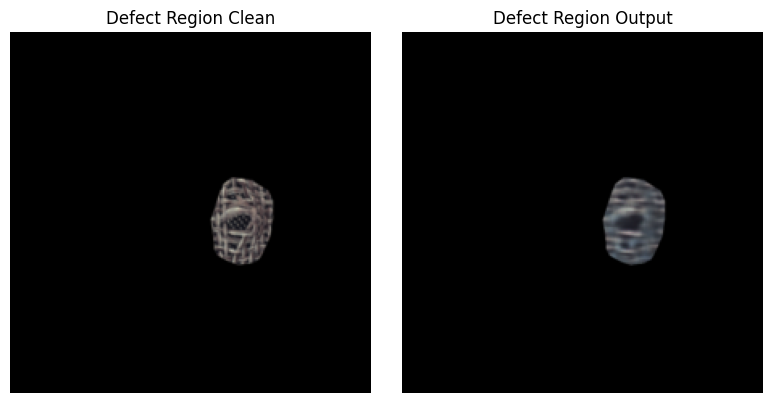

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.83662609882379, Defect SSIM: 0.9986648559570312
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 48.63424899831628, Defect SSIM: 0.9996992945671082
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.08968745219788, Defect SSIM: 0.9991159439086914
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 35.93467731629375, Defect SSIM: 0.9854748845100403
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 52.12133458504768, Defect SSIM: 0.9992784857749939
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 53.4048

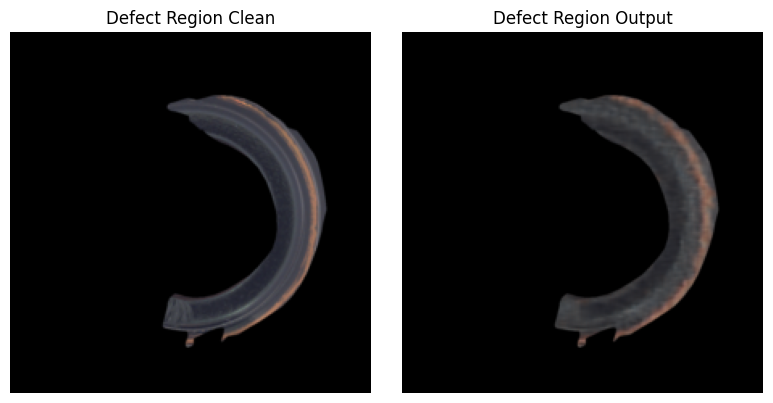

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 36.392798813549845, Defect SSIM: 0.9926950931549072
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.41487491175753, Defect SSIM: 0.997563898563385
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.35821450192597, Defect SSIM: 0.9995719790458679
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 42.42270471485164, Defect SSIM: 0.9989972114562988
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.91754480700138, Defect SSIM: 0.9977288246154785
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 40.1199

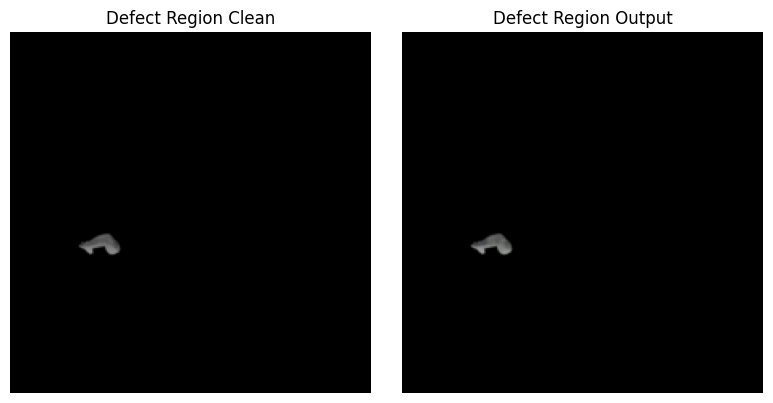

Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 53.15663532392933, Defect SSIM: 0.9999193549156189
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 51.565814153908846, Defect SSIM: 0.9999139308929443
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 42.65654493636275, Defect SSIM: 0.9968348145484924
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 34.825564774425494, Defect SSIM: 0.9791421890258789
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 39.53303077530855, Defect SSIM: 0.9973292350769043
Original shape: (224, 224, 3), Restored shape: (224, 224, 3)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 32.95

In [16]:
import matplotlib.pyplot as plt

psnr_values_defect = []
ssim_values_defect = []

with torch.no_grad():
    for degraded, clean, mask in test_loader:
        degraded = degraded.to(device)
        outputs = model_AE(degraded)

        # Convert tensors to numpy arrays while keeping the batch dimension
        output_images = outputs.cpu().numpy()  # Shape: (batch_size, C, H, W)
        clean_images = clean.cpu().numpy()
        mask_images = mask.cpu().numpy()

        for i in range(output_images.shape[0]):  # Loop over each image in the batch
            output_image = output_images[i]  # Shape: (C, H, W)
            clean_image = clean_images[i]
            mask_image = mask_images[i]

            # Isolate defect regions using the mask
            defect_region_output = output_image * mask_image
            defect_region_clean = clean_image * mask_image

            # Transpose for displaying with matplotlib
            defect_region_output = np.transpose(defect_region_output, (1, 2, 0))  # (H, W, C)
            defect_region_clean = np.transpose(defect_region_clean, (1, 2, 0))

            # Calculate PSNR and SSIM over defect regions only
            psnr_defect, ssim_defect = calculate_metrics(defect_region_clean, defect_region_output)
            print(f'Defect PSNR: {psnr_defect}, Defect SSIM: {ssim_defect}')


            if i == 0: #Instead of showing all images in each batch, I am showing only first image in each batch for not to exceed file size while uploading in github
                # Display defect regions
                fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                axs[0].imshow(defect_region_clean)
                axs[0].axis('off')
                axs[0].set_title('Defect Region Clean')

                axs[1].imshow(defect_region_output)
                axs[1].axis('off')
                axs[1].set_title('Defect Region Output')

                plt.tight_layout()
                plt.show()

            # Append to lists
            psnr_values_defect.append(psnr_defect)
            ssim_values_defect.append(ssim_defect)

    # Calculate average defect PSNR and SSIM
    average_psnr_defect = np.mean(psnr_values_defect)
    average_ssim_defect = np.mean(ssim_values_defect)

# Print or save the defect-specific average PSNR and SSIM
print(f"Average PSNR for defect regions: {average_psnr_defect:.2f}")
print(f"Average SSIM for defect regions: {average_ssim_defect:.2f}")


In [20]:
import os
import matplotlib.pyplot as plt

# Set up output folder
output_folder = "output_images"
os.makedirs(output_folder, exist_ok=True)

# Initialize lists to hold PSNR and SSIM values
psnr_values = []
ssim_values = []

# Initialize file for saving PSNR and SSIM metrics
metrics_file = os.path.join(output_folder, "metrics.txt")
with open(metrics_file, "w") as f:
    f.write("PSNR and SSIM values for each test image:\n\n")

with torch.no_grad():
    for idx, (degraded, clean, mask) in enumerate(test_loader):
        degraded = degraded.to(device)
        outputs = model_AE(degraded)

        # Convert tensors to numpy arrays for each image in the batch
        output_images = outputs.cpu().numpy()  # Shape: (batch_size, C, H, W)
        clean_images = clean.cpu().numpy()
        mask_images = mask.cpu().numpy()

        for i in range(output_images.shape[0]):  # Loop over each image in the batch
            output_image = output_images[i].squeeze()  # Shape: (C, H, W) or (H, W)
            clean_image = clean_images[i].squeeze()
            mask_image = mask_images[i].squeeze()

            # Save each output image to the folder
            output_img = np.transpose(output_image, (1, 2, 0)) if output_image.ndim == 3 else output_image
            output_path = os.path.join(output_folder, f"output_image_{idx * test_loader.batch_size + i}.png")
            plt.imsave(output_path, output_img, cmap='gray' if output_img.ndim == 2 else None)

            # Calculate PSNR and SSIM over the entire image
            psnr_value, ssim_value = calculate_metrics(clean_image, output_image)

            # Calculate metrics over defect regions
            defect_region_output = output_image * mask_image
            defect_region_clean = clean_image * mask_image

            # Determine `win_size` based on smallest dimension of defect regions
            smallest_dimension = min(defect_region_clean.shape[-2:])
            win_size = smallest_dimension if smallest_dimension % 2 == 1 else smallest_dimension - 1

            # Calculate defect-specific PSNR and SSIM with adjusted `win_size`
            psnr_defect, ssim_defect = calculate_metrics(defect_region_clean, defect_region_output)

            # Append the metrics
            psnr_values.append(psnr_value)
            ssim_values.append(ssim_value)

            # Write metrics for each image to the file
            with open(metrics_file, "a") as f:
                f.write(f"Image {idx * test_loader.batch_size + i + 1}: PSNR = {psnr_value:.2f}, SSIM = {ssim_value:.4f}\n")
                f.write(f"Defect Region: PSNR = {psnr_defect:.2f}, SSIM = {ssim_defect:.4f}\n\n")
    
    # Calculate and save average PSNR and SSIM
    average_psnr = np.mean(psnr_values)
    average_ssim = np.mean(ssim_values)

    # Write average metrics to the file
    with open(metrics_file, "a") as f:
        f.write("\nAverage PSNR and SSIM for the entire test set:\n")
        f.write(f"Average PSNR: {average_psnr:.2f}\n")
        f.write(f"Average SSIM: {average_ssim:.4f}\n")

# Print average values
print(f"Average PSNR for the entire validation set: {average_psnr:.2f}")
print(f"Average SSIM for the entire validation set: {average_ssim:.2f}")


Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original s